# Producing the Main figure.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from kinematics_and_rotation.dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the data and make cuts.

In [2]:
gaia_mc0 = pd.read_csv("../code/gaia_mc5.csv")

Load Travis' masses

In [3]:
travis = pd.read_csv("Ruth_McQuillan_Masses_Out.csv")
masses = pd.DataFrame(dict({"kepid": travis.KIC.values, "Mass": travis.iso_mass.values}))
masses.head()
gaia_mc0 = pd.merge(masses, gaia_mc0, how="right", on="kepid", suffixes=["_berger", ""])

(21618, 134) no visual binaries or subgiants
9739


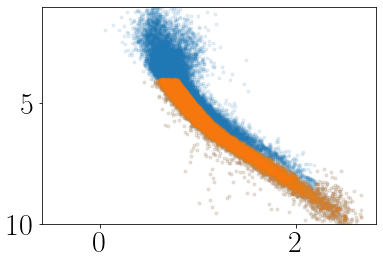

In [4]:
# Cut out visual binaries.
m = gaia_mc0.flag.values == 1
gaia_mc1 = gaia_mc0.iloc[m]*1
print(np.shape(gaia_mc1), "no visual binaries or subgiants")

plt.plot(gaia_mc0.bp_dered - gaia_mc0.rp_dered, gaia_mc0.abs_G, ".", alpha=.1)
plt.plot(gaia_mc1.bp_dered - gaia_mc1.rp_dered, gaia_mc1.abs_G, ".", alpha=.1)
plt.ylim(10, 1)
# gaia_mc1 = gaia_mc0

print(len(gaia_mc0) - len(gaia_mc1))

In [5]:
# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc1.age.values > .5
print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
# mint, maxt = 3500, 6000
mint, maxt = 3200, 6500
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

# Try cutting out stars with latitudes greater than bmax degrees
# bmax = 20
bmax = 15
# bmin = 10
# m &= (gaia_mc1.b.values < bmax) * (bmin < gaia_mc1.b.values)
m &= (gaia_mc1.b.values < bmax)
print(np.shape(gaia_mc1.iloc[m]), "no high latitude stars")

gaia_mc = gaia_mc1.iloc[m]

# # Restrict to stars with Vz
# m &= np.isfinite(gaia_mc1.vz.values)
# print(np.shape(gaia_mc1.iloc[m]), "only stars with Vz")

# Remove velocity outliers
# v_clipped, clipping_mask = sigma_clip(gaia_mc.vb.values, 3)
# gaia_mc = gaia_mc.iloc[clipping_mask]

(20880, 134) no large vb uncertainties
(20693, 134) no faint stars
(18780, 134) no rapid rotators
(18779, 134) no hot or cold stars
(13199, 134) no high latitude stars


Make cuts in rotation period.

In [6]:
x = gaia_mc.color_teffs.values
y = gaia_mc.Prot.values
v = gaia_mc.vb.values
verr = gaia_mc.vb_err.values
xerr = np.ones_like(x)*100
xlim = (maxt + 100, mint - 200)

tbins = np.linspace(min(x), max(x), 14)

period_bins = 10**np.linspace(np.log10(7), np.log10(50), 9)
mid_period_bins = period_bins[:-1] + .5*np.diff(period_bins)
period_masks = select_stars(gaia_mc, period_bins, "Prot")

pds, pderrs = [np.zeros((len(mid_period_bins), len(tbins[:-1]))) for i in range(2)]

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Calculate velocity dispersions.

In [7]:
for i, m in enumerate(period_masks):
    d, derr, k, kerr = MC_dispersion(x[m], v[m], xerr[m], verr[m], tbins, 1000, method="mad")
    pds[i, :] = d
    pderrs[i, :] = err_on_sample_std_dev(d, len(x[m]))

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [00:02<00:00, 368.06it/s]


Set the colour scale.

In [8]:
cmap = plt.cm.get_cmap('viridis_r')
# vmin, vmax = min(mid_period_bins), max(mid_period_bins)
# color_values = (mid_period_bins - vmin)/(vmax - vmin)
# rgba = cmap(color_values)

pvmin, pvmax = np.min(pds[pds > 0]), 25#np.max(pds[np.isfinite(pds)])
pcolor_values = (pds - pvmin)/(pvmax - pvmin)
prgba_plasma = cmap(pcolor_values)

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Load the Spada & Lanzafame models.

In [9]:
sl = pd.read_csv("../spada_lanzafame_models.csv")

Calculate gyro models.

In [10]:
from stardate.lhf import gk_rotation_model
from kinematics_and_rotation.photometric_teff import bprp_to_teff

xs_bprp = np.linspace(.3, 2.8, 100)
xs_teff = bprp_to_teff(xs_bprp)
ages = [.5, 1, 1.5, 2, 2.5, 4, 4.57]
prots = np.zeros((len(ages), len(xs_bprp)))
for i, age in enumerate(ages):
    prots[i, :] = 10**gk_rotation_model(np.log10(age*1e9), xs_bprp)

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


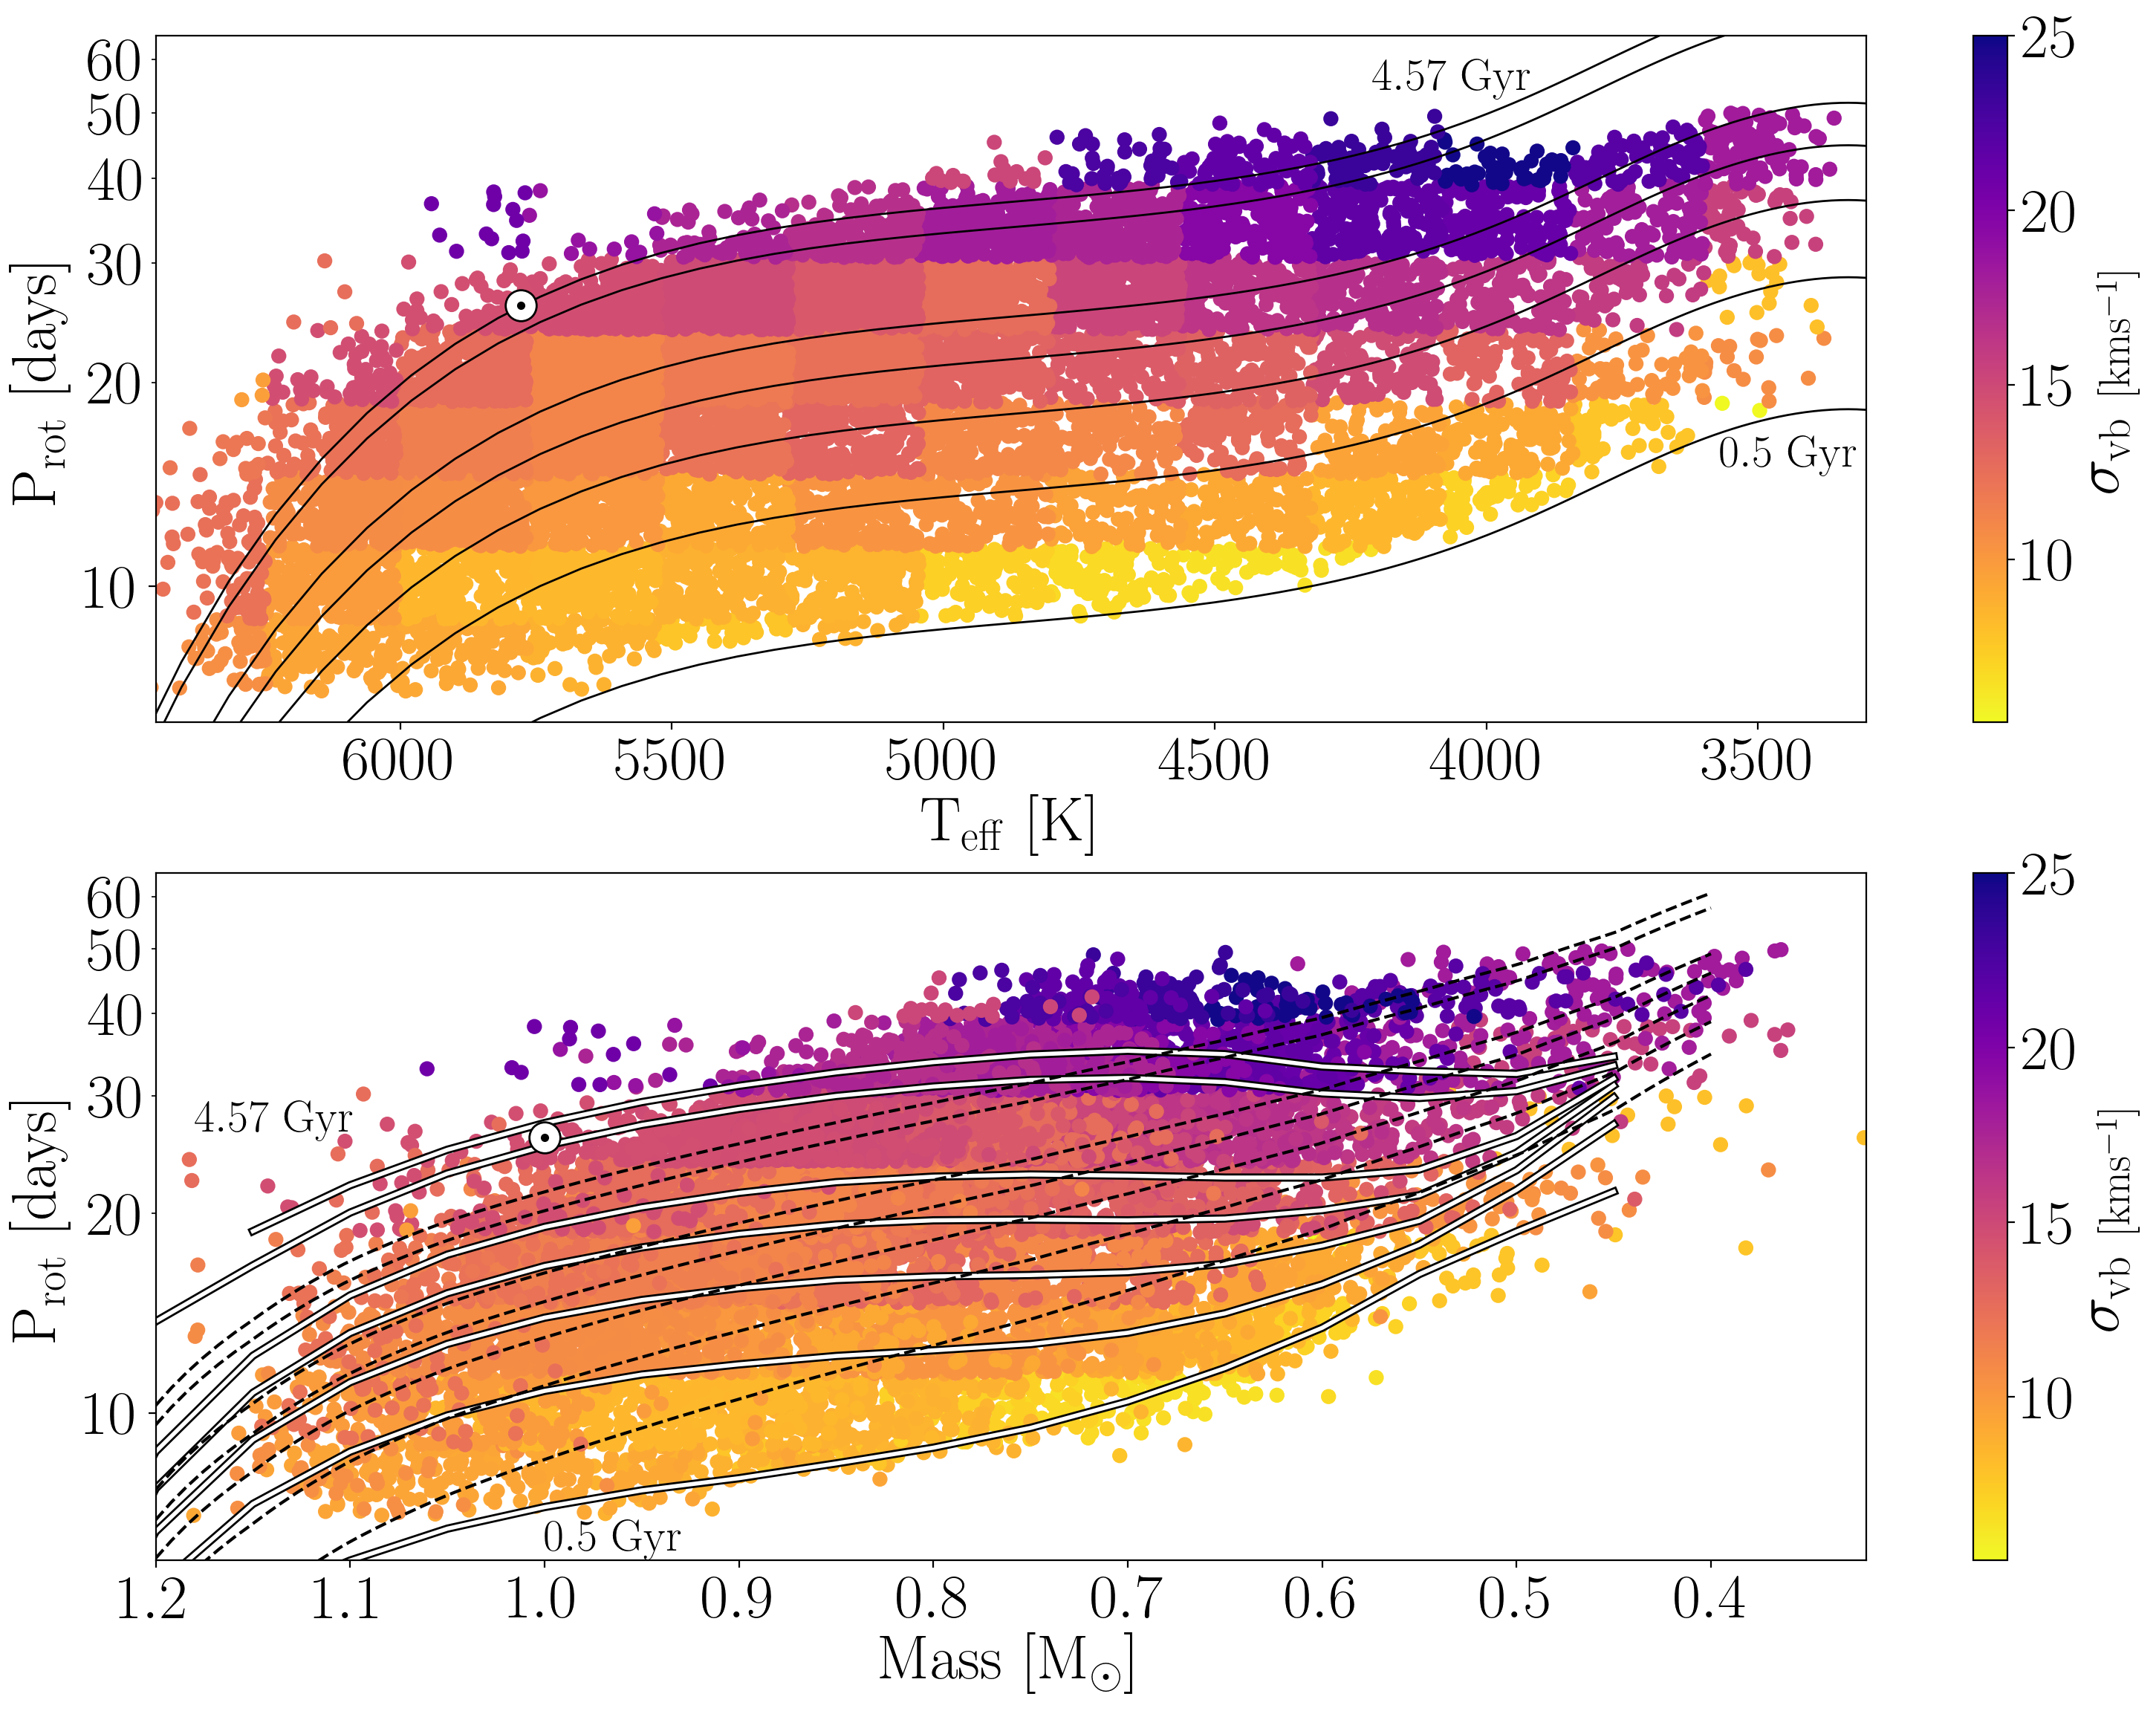

In [11]:
plotpar = {'axes.labelsize': 30,
           'font.size': 22,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)


fig = plt.figure(figsize=(16, 12), dpi=200)
ax1 = fig.add_subplot(211)

vb_dispersion, vb_dispersion_err, kepid_ = [], [], []
for i, m in enumerate(period_masks):
    for j in range(len(tbins)-1):
        tm = (x[m] > tbins[j]) * (x[m] < tbins[j+1])
        cb1 = plt.scatter(x[m][tm], y[m][tm], c=np.ones_like(y[m][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax, rasterized=True, zorder=1, s=40, cmap="plasma_r")
        vb_dispersion.append(np.ones_like(y[m][tm])*pds[i, j])
        vb_dispersion_err.append(np.ones_like(y[m][tm])*pderrs[i, j])
        kepid_.append(gaia_mc.kepid.values[m][tm])
#         print(tbins[j], period_bins[i], pds[i, j], pderrs[i, j])
vb_dispersion = [i for j in vb_dispersion for i in j]
vb_dispersion_err = [i for j in vb_dispersion_err for i in j]
kepid_ = [i for j in kepid_ for i in j]

lw0, lw1 = 5, 2
# Plot gyro models
for i in range(len(ages)):
    ax1.plot(xs_teff, prots[i, :], ls="-", lw=1, color="k", zorder=1,
             label="$\mathrm{Angus~et~al.~(2019)~model}$")

    
labels = ["$0.5~\mathrm{Gyr}$", "$4.57~\mathrm{Gyr}$"]
# ys = [6., 20]
# xs = [6060, 6320]
ys = [15., 54]
xs = [3570, 4210]
for i in range(len(ys)):
    ax1.text(xs[i], ys[i], labels[i])
    
ax1.plot(5778, 26, "wo", ms=15, mec="k", zorder=4)
ax1.plot(5778, 26, "k.", zorder=5)

plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
ax1.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax1.set_xlim(6450, 3300)
ax1.set_yscale("log")
ax1.set_ylim(6.3, 65)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")

import matplotlib
ax1.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("$%.0f$"))
ax1.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("$%.0f$"))
ax1.set_yticks([10, 20, 30, 40, 50, 60], minor=True)

ax2 = fig.add_subplot(212)
for i, m in enumerate(period_masks):
    for j in range(len(tbins)-1):
        tm = (x[m] > tbins[j]) * (x[m] < tbins[j+1])
        cb1 = plt.scatter(gaia_mc.Mass_berger.values[m][tm], y[m][tm], c=np.ones_like(y[m][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax, rasterized=True, zorder=1, cmap="plasma_r", s=40) # alpha=.3, edgecolor=""

plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
ax2.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax2.set_xlim(1.2, .32)
ax2.set_yscale("log")
ax2.set_ylim(6, 65)
ax2.set_xlabel("$\mathrm{Mass~[M_\odot]}$")

ax2.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("$%.0f$"))
ax2.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("$%.0f$"))
ax2.set_yticks([10, 20, 30, 40, 50, 60], minor=True)

ax2.plot(1, 26, "wo", ms=15, mec="k", zorder=4)
ax2.plot(1, 26, "k.", zorder=5)

# Spada & Lanzafame models
lw0, lw1 = 4, 2
ax2.plot(sl["Mass"], sl["p0.50"], "k", lw=lw0, zorder=1, label="$\mathrm{Spada~\&~Lanzafame~(2019)~model}$")
ax2.plot(sl["Mass"], sl["p1.00"], "k", lw=lw0, zorder=1, label="None")
ax2.plot(sl["Mass"], sl["p1.50"], "k", lw=lw0, zorder=1, label="None")
ax2.plot(sl["Mass"], sl["p2.00"], "k", lw=lw0, zorder=1, label=None)
ax2.plot(sl["Mass"], sl["p2.50"], "k", lw=lw0, zorder=1, label=None)
ax2.plot(sl["Mass"], sl["p4.00"], "k", lw=lw0, zorder=1, label=None)
ax2.plot(sl["Mass"], sl["p4.57"], "k", lw=lw0, zorder=1, label=None)

ax2.plot(sl["Mass"], sl["p0.50"], "w", lw=lw1, zorder=2, label=None)
ax2.plot(sl["Mass"], sl["p1.00"], "w", lw=lw1, zorder=2, label=None)
ax2.plot(sl["Mass"], sl["p1.50"], "w", lw=lw1, zorder=2, label=None)
ax2.plot(sl["Mass"], sl["p2.00"], "w", lw=lw1, zorder=2, label=None)
ax2.plot(sl["Mass"], sl["p2.50"], "w", lw=lw1, zorder=2, label=None)
ax2.plot(sl["Mass"], sl["p4.00"], "w", lw=lw1, zorder=2, label=None)
ax2.plot(sl["Mass"], sl["p4.57"], "w", lw=lw1, zorder=2, label=None)

# Add Barnes 2010 isochrones
import kinematics_and_rotation as kr
test_mass = np.linspace(1.2, .4, 100)
test_tau = kr.mass_to_tau_barnes(test_mass)

ages = [500, 1000, 1500, 2000, 2500, 4000, 4570]
for a in ages:
    p = kr.barnes_2010_model(1., a, 100, test_tau)
    plt.plot(test_mass, p, "k", ls="--")

xs = [1., 1.18]
ys = [6.2, 26.5]
for i in range(len(ys)):
    ax2.text(xs[i], ys[i], labels[i])

plt.tight_layout()
plt.subplots_adjust(hspace=.22)

# plt.savefig("../paper/main_figure.pdf")
# plt.savefig("main_figure")

In [12]:
dispersion_df = pd.DataFrame(dict({"kepid": kepid_, "sigma_vb": vb_dispersion, "sigma_vb_err": vb_dispersion_err}))
_sdf = pd.merge(gaia_mc, dispersion_df, how="left", on="kepid")
_sdf = _sdf.drop_duplicates(subset="kepid")
print(np.shape(dispersion_df), np.shape(_sdf), np.shape(gaia_mc))

(13066, 3) (13196, 136) (13199, 134)


In [13]:
sdf = pd.DataFrame(dict({"kepid": _sdf.kepid.values,
                            "Mass": _sdf.Mass_berger.values,
                            "Teff": _sdf.color_teffs.values,
                            "Prot": _sdf.Prot.values,
                            "Prot_err": _sdf.Prot_err.values,
                            "vb": _sdf.vb.values,
                            "vb_err": _sdf.vb_err.values,
                            "sigma_vb": _sdf.sigma_vb.values,
                            "sigma_vb_err": _sdf.sigma_vb_err.values}))
print(np.shape(sdf))

(13196, 9)


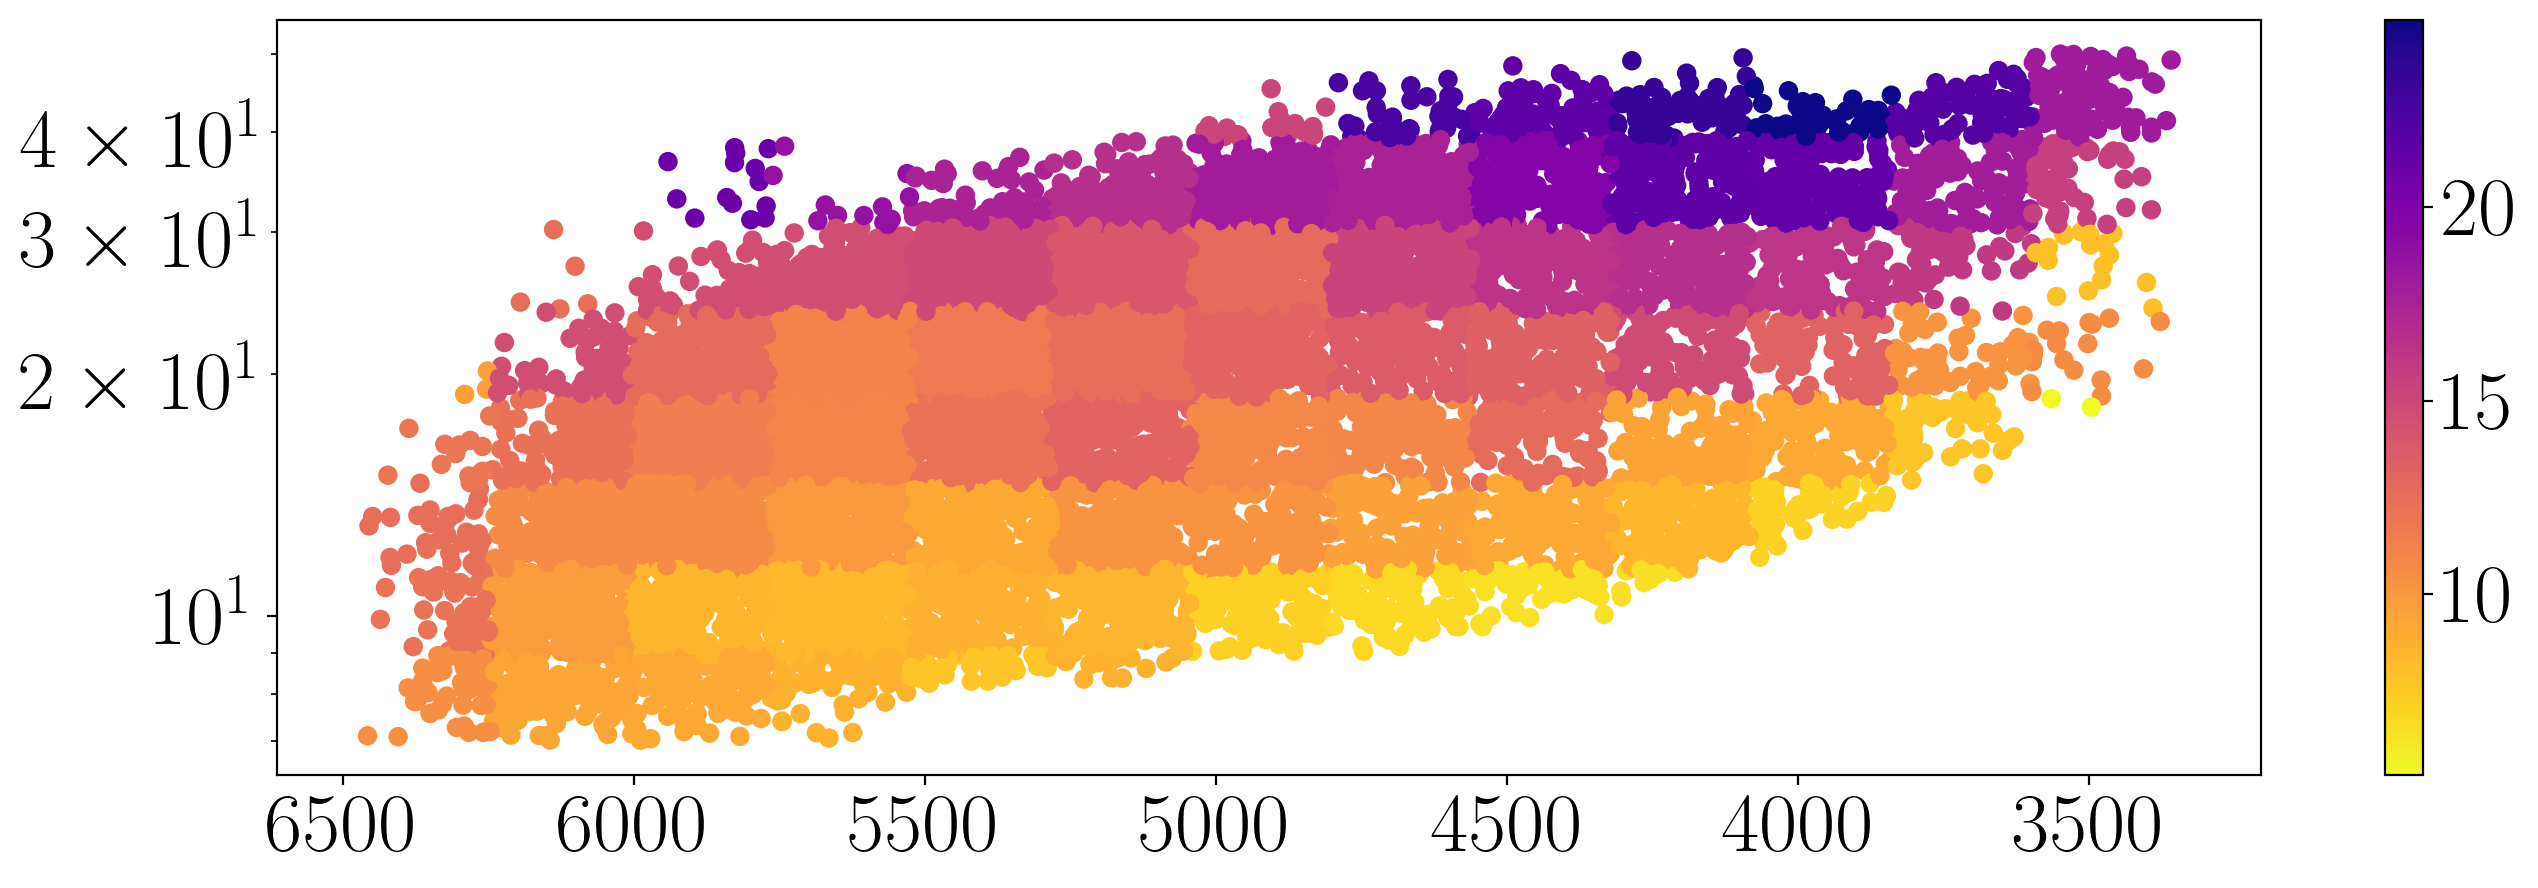

In [14]:
plt.figure(figsize=(16, 5), dpi=200)
plt.scatter(sdf.Teff, sdf.Prot, c=sdf.sigma_vb, cmap="plasma_r")
plt.colorbar()
plt.gca().invert_xaxis()
plt.yscale("log")

<ErrorbarContainer object of 3 artists>

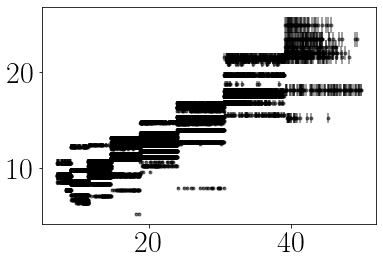

In [18]:
plt.errorbar(sdf.Prot, sdf.sigma_vb, yerr=sdf.sigma_vb_err, fmt="k.", zorder=0, alpha=.5)
# plt.scatter(sdf.Prot, sdf.sigma_vb, c=sdf.Teff, zorder=1)
# plt.colorbar()

In [20]:
sdf.to_csv("table_data.csv", index=False)

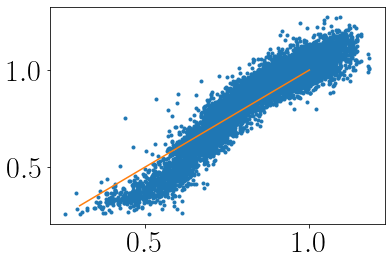

In [13]:
plt.plot(gaia_mc.Mass_berger, gaia_mc.Mass, ".")
xs = np.linspace(.3, 1, 100)
plt.plot(xs, xs, "C1")

In [24]:
print([col for col in gaia_mc.columns if "Prot" in col])

['Prot', 'Prot_err']
